# Quick Multi-Processing Tests

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import time
import numba
import pandas as pd

import pyspark
from pyspark.sql import SparkSession

Defining a an arbitrary function for testing. The function doesn't mean anything.

In [2]:
def fun(x):
    return x * np.sin(10*x) + np.tan(34*x) + np.log(x)

In [3]:
#Calcluate a value for testing
fun(10)

-1.9050256839815027

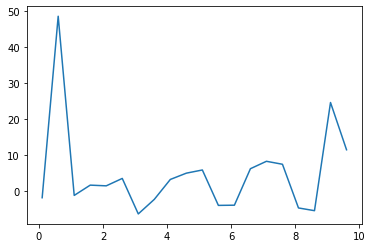

In [4]:
#Plot the function, for testing
x = np.arange(0.1,10,0.5)
plt.plot(x,fun(x));

### Benchmark 

Without any parallelism, for comparison purposes

In [5]:
%%timeit
n = int(1e7) ## Using a large number to iterate

def f(n):
    x = np.random.random(n)
    y = (x * np.sin(10*x) + np.tan(34*x) + np.log(x))
    
    
    return y
f(n)

652 ms ± 2.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


652 ms without parallel processing

### ProcessPool Execution

[ProcessPoolExecutor](https://docs.python.org/3/library/concurrent.futures.html) uses executes the processes asynchronously by using the number of processors assigned, in parallel.

In [20]:
%%time

with ProcessPoolExecutor(max_workers=4) as executor:
    result = executor.map(f, [int(1e7) for i in range(10)])

Wall time: 312 ms


Execution time dropped from 717 ms to 312 ms! This can be further optimized by specifying the number of processors to use and the chunk size. I will skip that for now.

### ThreadPool Execution

Similar to `ProcessPool` but uses threads instead of CPU.

In [23]:
%%time

with ThreadPoolExecutor(max_workers=4) as texecute:
    result_t = texecute.map(f, [int(1e7) for i in range(10)])

Wall time: 3.67 s


Far worse than the benchmark and the `ProcessPool`. I am not entirely sure why, but most lilelt because the interpreter is allowing only 1 thread to run or is creating an I/O bottleneck. 

### Using NUMBA

I have used `numba` for JIT compilation for some of my programs for bootstrapping.  

In [26]:
%%time
@numba.jit(nopython=True, parallel=True)
def f2(n):
    x = np.random.random(n)
    y = (x * np.sin(10*x) + np.tan(34*x) + np.log(x))
    
    
    return y
f2(int(1e7))

Wall time: 400 ms


array([-0.12330859, -5.99244525, -1.66685026, ..., -0.12572472,
       -1.40916039, -7.05138736])

400 ms - so better than the bechmark but almost as good as the `ProcessPool` method

In [6]:
spark=( SparkSession.builder.master("local")
       .appName("processingtest")
       .getOrCreate()
       )


In [7]:
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf


In [ ]:
def f2(n):
    x = np.random.random(n)
    y = (x * np.sin(10*x) + np.tan(34*x) + np.log(x))
    
    
    return y

In [8]:
n = int(1e7)
df = pd.DataFrame({"x":np.random.random(n)})

In [9]:
df.head(3)

,x
0,0.779242
1,0.484999
2,0.639646


In [10]:
def f3(x):
    return (x * np.sin(10*x) + np.tan(34*x) + np.log(x))
func_udf = udf(lambda x: f3(x), FloatType())

df_spark = spark.createDataFrame(df)

df_spark.withColumn("udf",func_udf("x"))

DataFrame[x: double, udf: float]

Inspecting the Spark job shows execution time as 0.4s (400 ms), as good as numba and `ProcessPool`. Spark would be much more scalable. Th eonly challenge here is the data needs to be converted to a tabular/dataframe format first. For most business process modeling scenarios that's usually not required and is an added step.

In [1]:
spark.stop()

### References : 

1. https://medium.com/@nyomanpradipta120/why-you-should-use-threadpoolexecutor-instead-processpoolexecutor-based-on-ctf-challenge-f51e838df351

2. https://docs.python.org/3/library/concurrent.futures.html


